In [1]:
import loompy
import numpy as np
import pandas as pd

from dfply import *

### from ggplot import *
# from plotnine import *

### Make sure you use the Python 3 (py3_anaconda3_PT180510) environment
# import sys
# print(sys.executable) # /tools/anaconda/3-4.4.0/envs/py3_anaconda3_PT180510/bin/python
# print(sys.version) # 3.6.4 |Anaconda, Inc.| (default, Jan 16 2018, 18:10:19) [GCC 7.2.0]

In [4]:
!ls

explore_and_export_mousebrain_loom_agg.ipynb
explore_mousebrain.R
export_mousebrain_ctc_log_avg_data.ipynb
export_mousebrain_loom.ipynb
import_mousebrain_to_seurat.R
mousebrain_anova.ipynb
mousebrain_beta.ipynb
mousebrain_ges.ipynb
mousebrain-SEM_models-old_workflow.R
mousebrain-SEM_models.R
mousebrain-SEM_models-skene_quick_and_dirty.R


### Coonect to loompy and make data frame

In [5]:
file_loom = "/data/pub-others/zeisel-biorxiv-2018/data/l5_all.loom"
with loompy.connect(file_loom) as ds:
    ### Make data frame
    # ds.ra.Gene (Gene names) contains 66 duplicate gene names
    df = pd.DataFrame(ds[:, :].astype(int), index=ds.ra.Accession, columns=ds.ca.CellID)
    df.columns = pd.MultiIndex.from_arrays([ds.ca.CellID, ds.ca.ClusterName], names=["CellID", "ClusterName"])

In [6]:
df.columns.get_level_values(level=0) # --> CellID
df.columns.get_level_values(level=1) # --> ClusterName

Index(['ENT9', 'ENT9', 'ENT9', 'ENT9', 'ENT9', 'ENT9', 'ENT9', 'ENT9', 'ENT9',
       'ENT9',
       ...
       'PSNP6', 'PSNP6', 'PSNP6', 'PSNP6', 'PSNP6', 'PSNP6', 'PSNP6', 'PSNP6',
       'PSNP6', 'PSNP6'],
      dtype='object', name='ClusterName', length=160796)

### common transcript count (ctc) normalization and log-transformation

In [7]:
### OBS INEFFICIENT: this creates a COPY of the data frame.
df_ctc_log = np.log(1+df/df.sum(axis=0)*1e4) # column sum. Seurat default scale.factor is '10000'
del df # clean up

KeyboardInterrupt: 

### Split into groups

In [ ]:
list_arrays = []
for lvl in df_ctc_log.columns.get_level_values(level="ClusterName").unique():
    print(lvl)
    list_arrays.append(df_ctc_log.xs(lvl, level="ClusterName", axis=1))
    # REF xs() : https://pandas.pydata.org/pandas-docs/stable/advanced.html#cross-section

### Run ANOVA

In [ ]:
from scipy import stats
# https://docs.scipy.org/doc/scipy-0.16.1/reference/generated/scipy.stats.f_oneway.html
# dict_results = {}
df_anova = pd.DataFrame(index=df_ctc_log.index)
for idx_gene in range(len(df_ctc_log.index)): # loop over all genes
    if idx_gene % 100 == 0:
        print(idx_gene)
    gene_id = df_ctc_log.index[idx_gene]
    f = stats.f_oneway(*[df_tmp.values[idx_gene,:] for df_tmp in list_arrays])
    df_anova.loc[gene_id, "pvalue"] = f.pvalue
    df_anova.loc[gene_id, "statistic"] = f.statistic
    # dict_results[gene_id] = f.pvalue
    # dict_results[gene_id] = f.statistic

### INFO
# stats.f_oneway(

In [ ]:
# Inspect results
# df_anova[df_anova['pvalue'] > 0.00001]

### Sort
df_anova.sort_values("pvalue",ascending=False, inplace=True)

In [44]:
from scipy import stats
### Testing
# x = np.array([1,2,3,4,1,2,3])
# y = np.array([11,22,53,43,12,12,10])
x = np.array([1]*101)
y = np.array([0]*6)
# z = np.array([2]*10)
z = np.array([0]*10)
f = stats.f_oneway(*[x, y, z])
print(f.pvalue)
print(f.statistic)

# Z5: 0.0 / inf
# Z10: nan / -3.4983318534038676e+16
# Z100: 0.0 / inf


### Warning if all groups are constants
# RuntimeWarning: divide by zero encountered in double_scalars
# f = msb / msw

nan
-2.2160019704933293e+17


In [18]:
z = np.array([2]*10)
z

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

### Export results

In [ ]:
df_anova.to_csv("mousebrain.pre_calc.sporadically_expressed_genes.anova.csv.gz", compression="gzip")

### Count how many genes are present after ortholog mapping

In [ ]:
### Define sporatically expressed genes
genes_sporadically = df_anova[df_anova['pvalue'] > 0.00001].index # 0.00001 is Skene cut-off
genes_sporadically

In [ ]:
file_ortholog = "/projects/timshel/sc-genetics/sc-genetics/data/gene_annotations/gene_annotation.hsapiens_mmusculus_unique_orthologs.GRCh37.ens_v91.txt.gz"
df_ortho = pd.read_csv(file_ortholog, sep="\t")
df_ortho.head()

In [ ]:
### Get sporadically genes that has orthologs
genes_sporadically_ortholog = genes_sporadically[genes_sporadically.isin(df_ortho["mmusculus_homolog_ensembl_gene"])]
genes_sporadically_ortholog 
# ---> 462 genes with NO ctc_log transformation
# ---> XXX genes with ctc_log transformation

In [ ]:
### Ortholog map to human
genes_sporadically_ortholog_human_id = df_ortho[df_ortho["mmusculus_homolog_ensembl_gene"].isin(genes_sporadically_ortholog)]["ensembl_gene_id"]
genes_sporadically_ortholog_human_id.head()

### Check average expression

In [104]:
### Read expression data
file_expr = "/projects/timshel/sc-genetics/sc-genetics/data/expression/mousebrain/mousebrain.celltype_expr.avg_expr.hsapiens_orthologs.csv.gz"
df_expr = pd.read_csv(file_expr, index_col=0)
df_expr.head()

,ENT9,ENT8,ENT6,ENT5,ENT4,ENT7,ENT3,ENT2,ENT1,ENTG1,...,PSPEP8,PSNF2,PSNF3,PSNF1,PSNP1,PSNP3,PSNP2,PSNP5,PSNP4,PSNP6
gene,,,,,,,,,,,,,,,,,,,,,
ENSG00000141668,2.330858,0.268913,0.188568,0.090219,0.046593,0.000000,0.011692,0.015235,0.072049,0.035456,...,0.000000,1.237977,0.230941,1.519044,0.245476,0.000000,0.000000,0.011752,0.000000,0.002043
ENSG00000204624,0.341488,0.000000,0.000000,0.000000,0.000000,0.059498,0.000000,0.008833,0.000000,0.000000,...,0.136221,0.109006,0.049078,0.087294,0.000000,0.001218,0.070288,0.010621,0.000000,0.010962
ENSG00000187848,2.058074,0.655755,0.137839,0.585869,0.470494,0.966922,0.945266,0.747460,1.040404,0.011592,...,0.022039,0.000000,0.000000,0.000000,0.009232,0.002483,0.000000,0.188068,0.018544,0.662790
ENSG00000171522,0.526382,0.071253,0.223404,0.212315,0.190167,0.200587,0.088043,0.161336,0.271647,0.000000,...,0.000000,0.107090,0.169826,0.073189,0.039981,0.024541,0.047702,0.064767,0.087250,0.093792
ENSG00000183662,2.130974,2.112896,1.763393,1.362093,0.988794,1.209140,0.078839,0.095011,1.260892,0.000000,...,0.000000,0.290153,0.423142,0.061954,0.007465,0.006114,0.000000,0.006742,0.000000,0.003821


In [107]:
### Get spradically
df_expr_sporadically = df_expr.loc[genes_sporadically_ortholog_human_id]
df_expr_sporadically.head()

,ENT9,ENT8,ENT6,ENT5,ENT4,ENT7,ENT3,ENT2,ENT1,ENTG1,...,PSPEP8,PSNF2,PSNF3,PSNF1,PSNP1,PSNP3,PSNP2,PSNP5,PSNP4,PSNP6
gene,,,,,,,,,,,,,,,,,,,,,
ENSG00000176136,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ENSG00000185231,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ENSG00000215474,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ENSG00000258713,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ENSG00000124092,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.014775,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


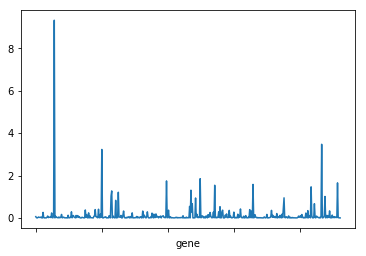

In [110]:
%matplotlib inline
df_expr_sporadically.sum(axis=1).plot()